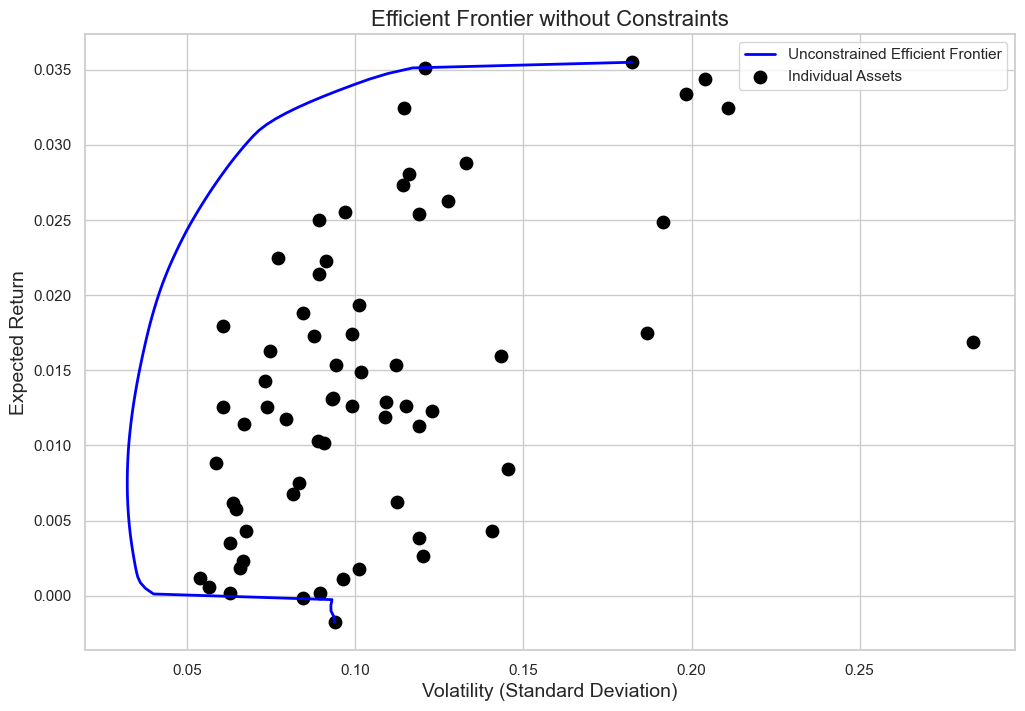

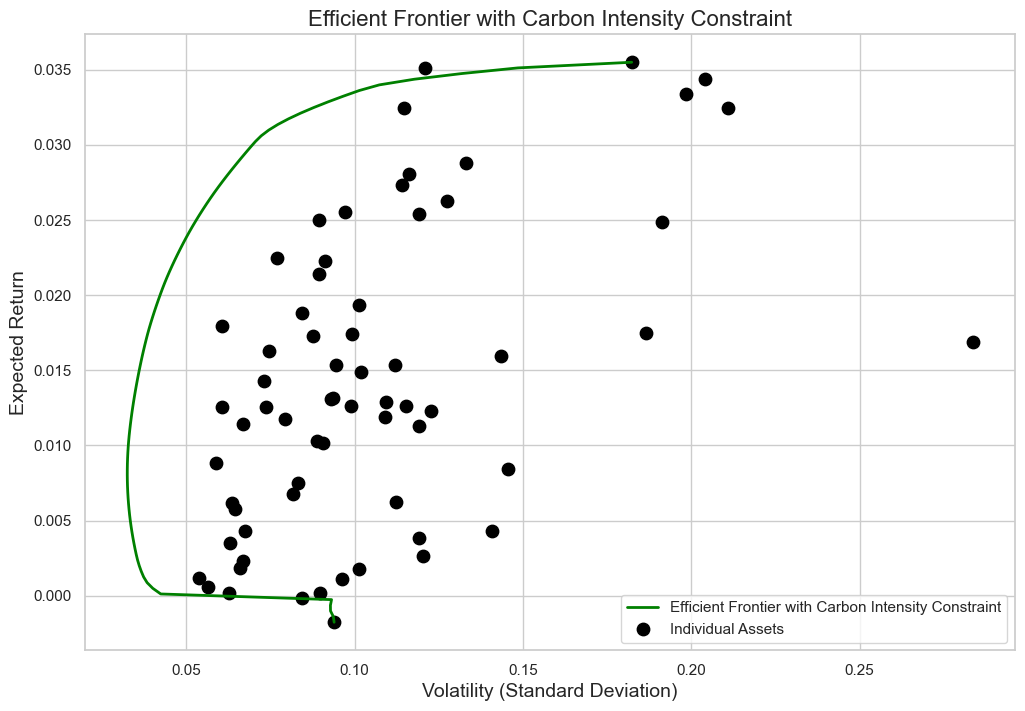

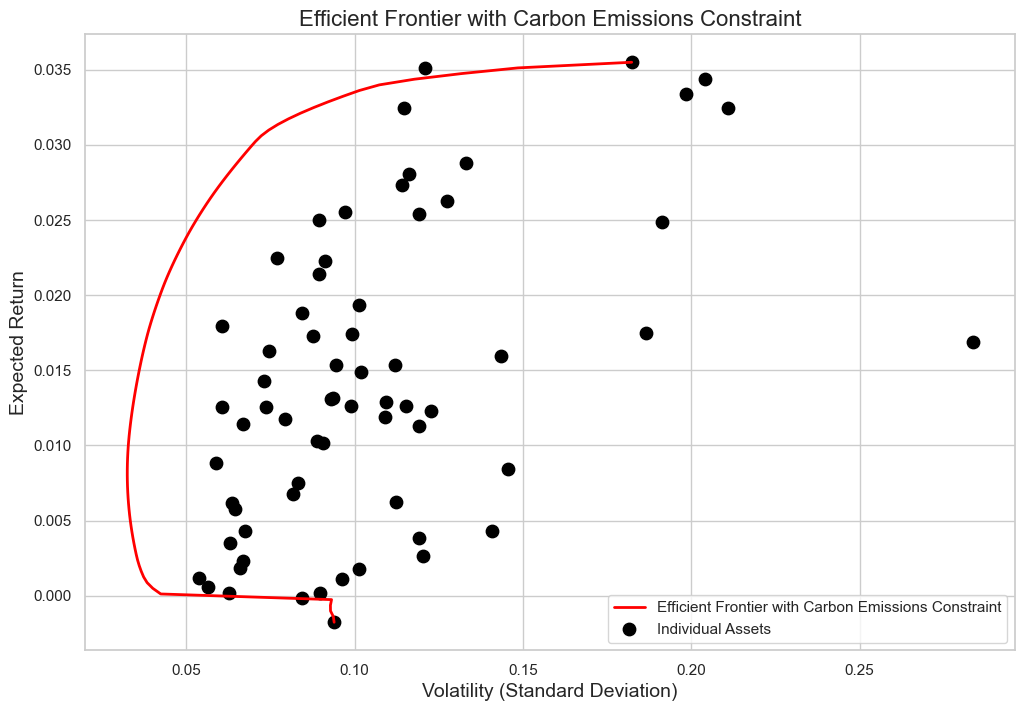

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns

# Define the path to the folder containing the CSV files
base_path = '/Users/gurpreetkalsi/Downloads/OneDrive_1_15-07-2024'

# Load the returns data
returns_data = pd.read_csv(f'{base_path}/Market Price_66 stocks.csv', index_col='Date', parse_dates=True)
carbon_intensity_data = pd.read_csv(f'{base_path}/weighted_carbon_intensity.csv')
carbon_emissions_data = pd.read_csv(f'{base_path}/weighted_carbon_intensity.csv')  # Using the same file for demonstration

# Set index to 'Ticker' if it exists in the data
if 'Ticker' in carbon_intensity_data.columns:
    carbon_intensity_data.set_index('Ticker', inplace=True)
if 'Ticker' in carbon_emissions_data.columns:
    carbon_emissions_data.set_index('Ticker', inplace=True)

# Filter the carbon intensity and emissions data to include only the tickers present in returns data
tickers = returns_data.columns
carbon_intensity = carbon_intensity_data.loc[tickers, 'Weighted Carbon Intensity'].values
carbon_emissions = carbon_emissions_data.loc[tickers, 'Weighted Carbon Intensity'].values  # Adjust accordingly if different column name

# Check for NaN or infinite values and handle them
returns_data.replace([np.inf, -np.inf], np.nan, inplace=True)
returns_data.dropna(how='any', inplace=True)
returns_data = returns_data.astype(np.float64)
returns_data = returns_data[np.isfinite(returns_data).all(axis=1)]

# Calculate expected returns and sample covariance matrix
mu = returns_data.mean()
S = returns_data.cov()

# Define the optimization problem
def portfolio_performance(weights, mu, S, rf=0.0):
    returns = np.dot(weights, mu)
    std_dev = np.sqrt(np.dot(weights.T, np.dot(S, weights)))
    sharpe_ratio = (returns - rf) / std_dev
    return -sharpe_ratio

def optimize_portfolio(mu, S, constraints=None):
    num_assets = len(mu)
    args = (mu, S)
    if constraints is None:
        constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
    bounds = tuple((0.0, 1.0) for asset in range(num_assets))
    result = minimize(portfolio_performance, num_assets * [1. / num_assets,], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# Function to calculate efficient frontier points
def calculate_efficient_frontier(mu, S, num_points=100, constraints=None):
    results = []
    for target_return in np.linspace(mu.min(), mu.max(), num_points):
        cons = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                {'type': 'eq', 'fun': lambda x: np.dot(x, mu) - target_return}]
        if constraints:
            cons.extend(constraints)
        result = optimize_portfolio(mu, S, constraints=cons)
        if result.success:
            std_dev = np.sqrt(np.dot(result.x.T, np.dot(S, result.x)))
            results.append((std_dev, target_return))
    return np.array(results)

# Calculate the efficient frontier for the three scenarios

# 1. Unconstrained Portfolio
ef_unconstrained = calculate_efficient_frontier(mu, S)

# 2. Constrained Portfolio: Carbon Intensity Constraint
constraints_carbon_intensity = [{'type': 'ineq', 'fun': lambda x: 0.2 - np.dot(carbon_intensity, x)}]
ef_constrained_carbon_intensity = calculate_efficient_frontier(mu, S, constraints=constraints_carbon_intensity)

# 3. Constrained Portfolio: Carbon Emissions Constraint (Using Carbon Intensity data for demo)
constraints_carbon_emissions = [{'type': 'ineq', 'fun': lambda x: 0.2 - np.dot(carbon_emissions, x)}]
ef_constrained_carbon_emissions = calculate_efficient_frontier(mu, S, constraints=constraints_carbon_emissions)

# Scatter plot of individual assets
asset_volatility = np.sqrt(np.diag(S))
asset_returns = mu.values

# Plot settings for better visuals
sns.set(style='whitegrid')
marker_size = 80
line_width = 2

# Plot the unconstrained efficient frontier
plt.figure(figsize=(12, 8))
plt.plot(ef_unconstrained[:, 0], ef_unconstrained[:, 1], label='Unconstrained Efficient Frontier', color='blue', linewidth=line_width)
plt.scatter(asset_volatility, asset_returns, marker='o', s=marker_size, c='black', label='Individual Assets')
plt.xlabel('Volatility (Standard Deviation)', fontsize=14)
plt.ylabel('Expected Return', fontsize=14)
plt.title('Efficient Frontier without Constraints', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

# Plot the constrained efficient frontier (Carbon Intensity)
plt.figure(figsize=(12, 8))
plt.plot(ef_constrained_carbon_intensity[:, 0], ef_constrained_carbon_intensity[:, 1], label='Efficient Frontier with Carbon Intensity Constraint', color='green', linewidth=line_width)
plt.scatter(asset_volatility, asset_returns, marker='o', s=marker_size, c='black', label='Individual Assets')
plt.xlabel('Volatility (Standard Deviation)', fontsize=14)
plt.ylabel('Expected Return', fontsize=14)
plt.title('Efficient Frontier with Carbon Intensity Constraint', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

# Plot the constrained efficient frontier (Carbon Emissions)
plt.figure(figsize=(12, 8))
plt.plot(ef_constrained_carbon_emissions[:, 0], ef_constrained_carbon_emissions[:, 1], label='Efficient Frontier with Carbon Emissions Constraint', color='red', linewidth=line_width)
plt.scatter(asset_volatility, asset_returns, marker='o', s=marker_size, c='black', label='Individual Assets')
plt.xlabel('Volatility (Standard Deviation)', fontsize=14)
plt.ylabel('Expected Return', fontsize=14)
plt.title('Efficient Frontier with Carbon Emissions Constraint', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()
